In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the stock prices dataset
stock_data = pd.read_csv("C:/Users/Poojith/OneDrive/Desktop/prices-split-adjusted.csv")
stock_df = pd.DataFrame(stock_data)

# Displaying the first few rows of the DataFrame
print(stock_df.head())



         date symbol        open       close         low        high  \
0  2016-01-05   WLTW  123.430000  125.839996  122.309998  126.250000   
1  2016-01-06   WLTW  125.239998  119.980003  119.940002  125.540001   
2  2016-01-07   WLTW  116.379997  114.949997  114.930000  119.739998   
3  2016-01-08   WLTW  115.480003  116.620003  113.500000  117.440002   
4  2016-01-11   WLTW  117.010002  114.970001  114.089996  117.330002   

      volume  
0  2163600.0  
1  2386400.0  
2  2489500.0  
3  2006300.0  
4  1408600.0  


In [2]:
# Analyzing dataset features
print(stock_df.describe())


                open          close            low           high  \
count  851264.000000  851264.000000  851264.000000  851264.000000   
mean       64.993618      65.011913      64.336541      65.639748   
std        75.203893      75.201216      74.459518      75.906861   
min         1.660000       1.590000       1.500000       1.810000   
25%        31.270000      31.292776      30.940001      31.620001   
50%        48.459999      48.480000      47.970001      48.959999   
75%        75.120003      75.139999      74.400002      75.849998   
max      1584.439941    1578.130005    1549.939941    1600.930054   

             volume  
count  8.512640e+05  
mean   5.415113e+06  
std    1.249468e+07  
min    0.000000e+00  
25%    1.221500e+06  
50%    2.476250e+06  
75%    5.222500e+06  
max    8.596434e+08  


In [3]:
# Checking for missing values across all columns
missing_values = stock_df.isnull().mean() * 100
print(missing_values)


date      0.0
symbol    0.0
open      0.0
close     0.0
low       0.0
high      0.0
volume    0.0
dtype: float64


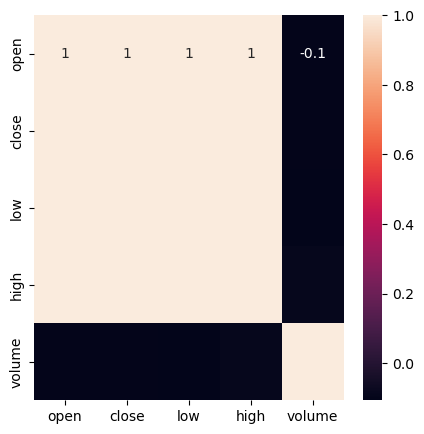

In [4]:
# Focusing on a single stock symbol for detailed analysis
stock_df_filtered = stock_df[stock_df['symbol'] == 'AAP']

# Selecting only numeric columns for correlation analysis
numeric_cols = stock_df_filtered.select_dtypes(include=[np.number])

# Examining correlations among numeric features
correlation_matrix = numeric_cols.corr()
plt.figure(figsize=(5,5))
sns.heatmap(correlation_matrix, annot=True)
plt.show()


In [5]:
# Function to identify highly correlated columns
def identify_highly_correlated(data, threshold):
    relevant_features = []
    correlation_values = []

    # Iterating over the index (column names) of the data Series
    for index in data.index:
        if abs(data[index]) > threshold:  # Using the Series directly
            relevant_features.append(index)
            correlation_values.append(data[index])
    
    correlated_df = pd.DataFrame(data=correlation_values, index=relevant_features, columns=['Correlation Value'])
    return correlated_df


In [6]:
# Identifying features with high correlation to 'close' price
high_correlation = identify_highly_correlated(correlation_matrix['close'], 0.60)
print(high_correlation)

# Filtering the dataset based on identified features
filtered_df = stock_df_filtered[high_correlation.index.tolist()]
print(filtered_df.head())


       Correlation Value
open            0.999382
close           1.000000
low             0.999615
high            0.999737
           open      close        low       high
253   40.700001  40.380001  40.360001  41.040001
720   40.299999  40.139999  39.720001  40.310001
1188  40.049999  40.490002  40.049999  40.779999
1656  39.549999  40.480000  39.549999  40.540001
2124  40.250000  40.639999  40.110001  40.820000


In [7]:
# Preparing data for model training
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X = filtered_df.drop(['close'], axis=1)
Y = filtered_df['close']
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Splitting the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, shuffle=False)

# Training a Linear Regression model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

linear_model = LinearRegression()
linear_model.fit(X_train, Y_train)


LinearRegression()

In [8]:
# Predicting and evaluating the Linear Regression model
Y_pred_linear = linear_model.predict(X_test)
print("Linear Regression R2 score:", r2_score(Y_test, Y_pred_linear))


Linear Regression R2 score: 0.9931342019332019


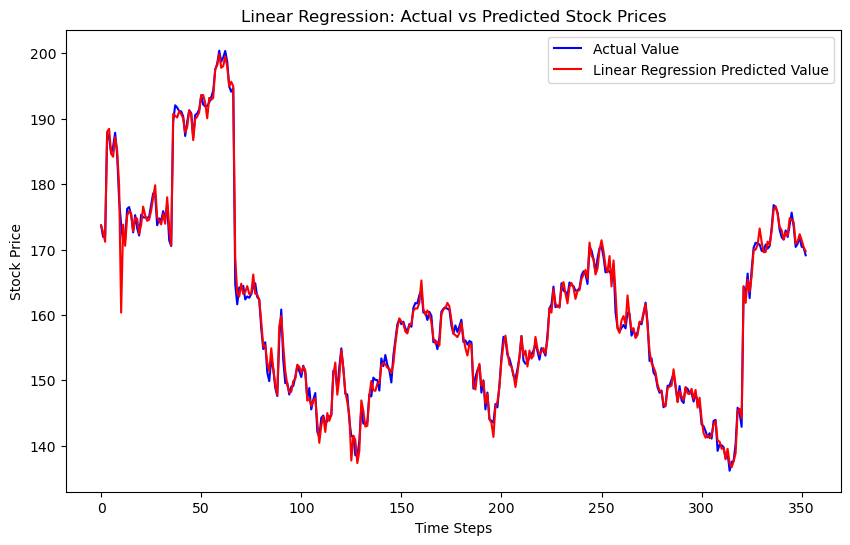

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(Y_test.reset_index(drop=True), label="Actual Value", color='blue')
plt.plot(Y_pred_linear, label="Linear Regression Predicted Value", color='red')
plt.title("Linear Regression: Actual vs Predicted Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [9]:
# Defining and training an ANN model
from keras.models import Sequential
from keras.layers import Dense

def create_ann_model(input_dim):
    model = Sequential([
        Dense(20, input_dim=input_dim, activation='relu'),
        Dense(25, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

ann_model = create_ann_model(X_train.shape[1])
ann_model.fit(X_train, Y_train, epochs=70, batch_size=10, validation_split=0.2)

# Predicting and evaluating the ANN model
Y_pred_ann = ann_model.predict(X_test)
print("ANN R2 score:", r2_score(Y_test, Y_pred_ann.flatten()))


C:\Users\Poojith\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 5941.4712 - val_loss: 19984.0605
Epoch 2/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4644.0674 - val_loss: 4077.2949
Epoch 3/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 355.6568 - val_loss: 128.8194
Epoch 4/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12.1271 - val_loss: 104.3602
Epoch 5/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.0203 - val_loss: 69.8755
Epoch 6/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6.9752 - val_loss: 45.0629
Epoch 7/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4940 - val_loss: 31.3749
Epoch 8/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.4359 - val_loss: 22.2146
Epoch 9/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.1356 - val_loss: 12.8984
Epoch 10/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3089 - val_loss: 8.3350
Epoch 11/70
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0000 - val_loss: 4.8624
Epoch 12/70
113/113 ━━━━━━━

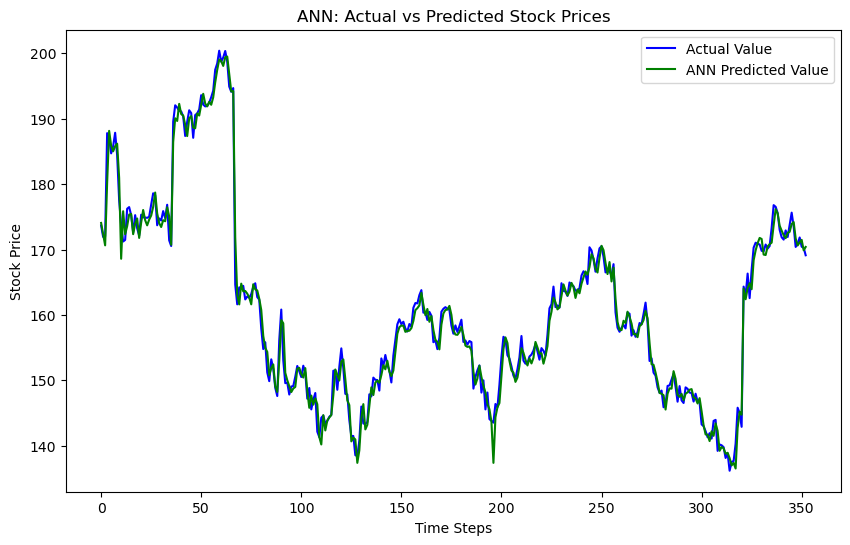

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(Y_test.reset_index(drop=True), label="Actual Value", color='blue')
plt.plot(Y_pred_ann.flatten(), label="ANN Predicted Value", color='green')
plt.title("ANN: Actual vs Predicted Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [11]:
# Reshaping input data for CNN
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

def create_cnn_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape))
    # Only add MaxPooling1D if the number of features/time steps after Conv1D is greater than 1
    if input_shape[0] > 3:  # Adjust based on kernel_size and your data
        model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

cnn_model = create_cnn_model(X_train_cnn.shape[1:])
cnn_model.fit(X_train_cnn, Y_train, epochs=50, batch_size=10, validation_split=0.2)

# Predicting and evaluating the CNN model
Y_pred_cnn = cnn_model.predict(X_test_cnn)
print("CNN R2 score:", r2_score(Y_test, Y_pred_cnn.flatten()))


Epoch 1/50


C:\Users\Poojith\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 6142.0181 - val_loss: 18941.3398
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4411.2944 - val_loss: 5136.0425
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 640.4210 - val_loss: 134.8496
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7676 - val_loss: 64.7769
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.6554 - val_loss: 51.2298
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.1797 - val_loss: 40.1649
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.8165 - val_loss: 27.3457
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.7283 - val_loss: 20.8193
Epoch 9/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.2551 - val_loss: 17.8696
Epoch 10/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3885 - val_loss: 10.9900
Epoch 11/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.2106 - val_loss: 7.9876
Epoch 12/50
113/113 ━━━━━━━━━━━━━━━━━━━

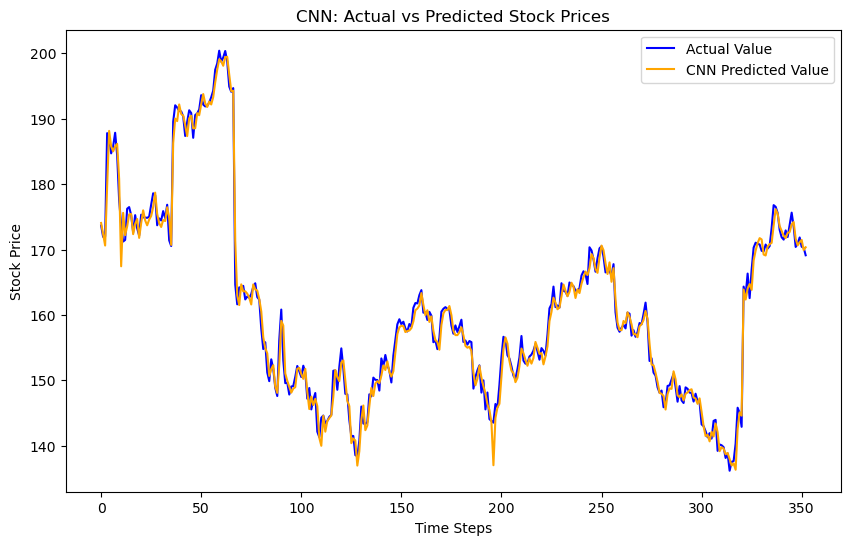

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(Y_test.reset_index(drop=True), label="Actual Value", color='blue')
plt.plot(Y_pred_cnn.flatten(), label="CNN Predicted Value", color='orange')
plt.title("CNN: Actual vs Predicted Stock Prices")
plt.xlabel("Time Steps")
plt.ylabel("Stock Price")
plt.legend()
plt.show()


In [51]:
# Create a DataFrame to hold the actual and predicted values
results_df = pd.DataFrame({'Actual': Y_test.reset_index(drop=True),
                           'Linear Regression': Y_pred_linear,
                           'ANN': Y_pred_ann.flatten(),
                           'CNN': Y_pred_cnn.flatten()})

# Display the DataFrame
print(results_df.head())


       Actual  Linear Regression         ANN         CNN
0  173.660004         173.682489  174.058212  174.055664
1  171.919998         172.593759  172.364670  172.377777
2  172.000000         171.182789  170.633713  170.607849
3  187.789993         187.980305  180.188446  179.645813
4  187.029999         188.440838  188.132950  188.128281


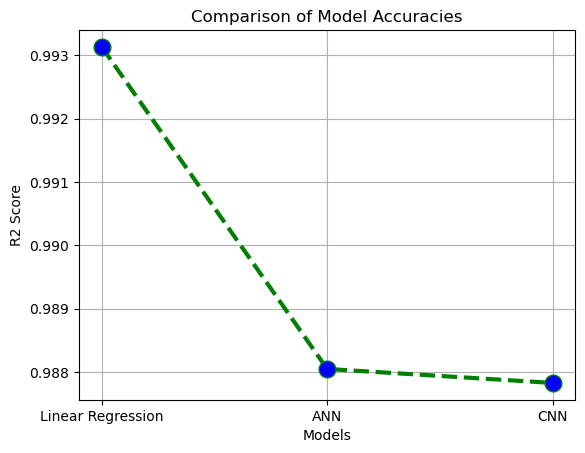

In [49]:
import matplotlib.pyplot as plt

# Assuming you have the R2 scores for Linear Regression, ANN, and CNN models
linear_regression_score = r2_score(Y_test, Y_pred_linear)
ann_score = r2_score(Y_test, Y_pred_ann.flatten())
cnn_score = r2_score(Y_test, Y_pred_cnn.flatten())

model_scores = [linear_regression_score, ann_score, cnn_score]
model_names = ['Linear Regression', 'ANN', 'CNN']

plt.plot(range(3), model_scores, color='green', linestyle='dashed', linewidth=3, marker='o', markerfacecolor='blue', markersize=12)
plt.ylabel('R2 Score')
plt.xlabel('Models')
plt.title("Comparison of Model Accuracies")
plt.xticks(range(3), model_names)
plt.grid(True)
plt.show()


Now we perform time series forecasting by transforming the data and apply LSTM, ANN and CNN models

In [55]:
def create_time_series_dataset(data, time_step=30):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

# Preparing time series data
time_step = 30
close_prices = stock_df_filtered['close'].values
X, Y = create_time_series_dataset(close_prices, time_step)

# Scaling time series data
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_scaled = scaler_X.fit_transform(X)

scaler_Y = MinMaxScaler(feature_range=(0, 1))
Y = Y.reshape(-1, 1)
Y_scaled = scaler_Y.fit_transform(Y)

In [26]:
# Splitting time series data into training and testing sets
X_train_ts, X_test_ts, Y_train_ts, Y_test_ts = train_test_split(X_scaled, Y_scaled, test_size=0.2, shuffle=False)

# Reshaping input to be [samples, time steps, features] for LSTM
X_train_ts = X_train_ts.reshape(X_train_ts.shape[0], X_train_ts.shape[1], 1)
X_test_ts = X_test_ts.reshape(X_test_ts.shape[0], X_test_ts.shape[1], 1)


In [27]:
# Training LSTM Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=input_shape),
        LSTM(50, return_sequences=False),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = create_lstm_model((X_train_ts.shape[1], 1))
lstm_model.fit(X_train_ts, Y_train_ts, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100


C:\Users\Poojith\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 0.0192 - val_loss: 0.0283
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0015 - val_loss: 9.1002e-04
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 4.6898e-04 - val_loss: 9.1051e-04
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 2.8331e-04 - val_loss: 8.4827e-04
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 4.1322e-04 - val_loss: 0.0011
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.3206e-04 - val_loss: 8.5113e-04
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.5063e-04 - val_loss: 8.4325e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 3.3667e-04 - val_loss: 8.3896e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.2898e-04 - val_loss: 8.0620e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 3.2169e-04 - val_loss: 9.6685e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 3.6444e-04 - val_loss: 8.2

In [28]:
# Predicting with LSTM Model
Y_pred_lstm = lstm_model.predict(X_test_ts)
Y_pred_lstm_inversed = scaler_Y.inverse_transform(Y_pred_lstm)  # Inverse scaling

# Evaluating LSTM Model
Y_test_ts_inversed = scaler_Y.inverse_transform(Y_test_ts)  # Inverse scaling for actual values
print("LSTM R2 score:", r2_score(Y_test_ts_inversed, Y_pred_lstm_inversed))


11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
LSTM R2 score: 0.9333652611262528


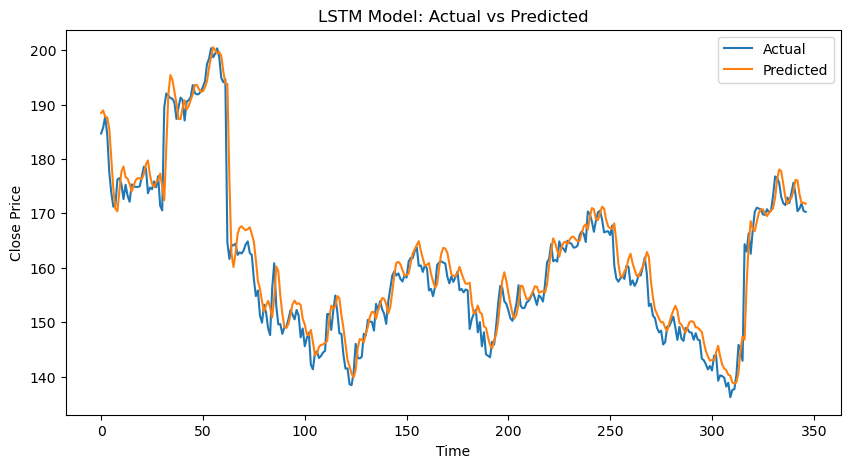

In [36]:
import matplotlib.pyplot as plt

# Plotting actual vs predicted values for LSTM Model
plt.figure(figsize=(10, 5))
plt.plot(Y_test_ts_inversed, label='Actual')
plt.plot(Y_pred_lstm_inversed, label='Predicted')
plt.title('LSTM Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()



In [29]:
# Creating and training ANN Model for Time Series
def create_ann_model(input_dim):
    model = Sequential([
        Dense(20, input_dim=input_dim, activation='relu'),
        Dense(25, activation='relu'),
        Dense(10, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

ann_model_ts = create_ann_model(X_train_ts.shape[1] * X_train_ts.shape[2])
ann_model_ts.fit(X_train_ts.reshape(X_train_ts.shape[0], X_train_ts.shape[1] * X_train_ts.shape[2]), Y_train_ts, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100


C:\Users\Poojith\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 0.0135 - val_loss: 0.0027
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0011 - val_loss: 0.0014
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.6936e-04 - val_loss: 0.0012
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.2844e-04 - val_loss: 0.0013
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.6657e-04 - val_loss: 9.4601e-04
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7779e-04 - val_loss: 0.0010
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.0230e-04 - val_loss: 8.8374e-04
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3964e-04 - val_loss: 7.6608e-04
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.7536e-04 - val_loss: 7.7990e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9973e-04 - val_loss: 6.6422e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.5959e-04 - val_loss: 6.5869e-04
Epoch 12/100
1

In [30]:
# Predicting with ANN Model
Y_pred_ann_ts = ann_model_ts.predict(X_test_ts.reshape(X_test_ts.shape[0], X_test_ts.shape[1] * X_test_ts.shape[2]))
Y_pred_ann_ts_inversed = scaler_Y.inverse_transform(Y_pred_ann_ts)  # Inverse scaling

# Evaluating ANN Model for Time Series
print("ANN Time Series R2 score:", r2_score(Y_test_ts_inversed, Y_pred_ann_ts_inversed))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
ANN Time Series R2 score: 0.9208947231711797


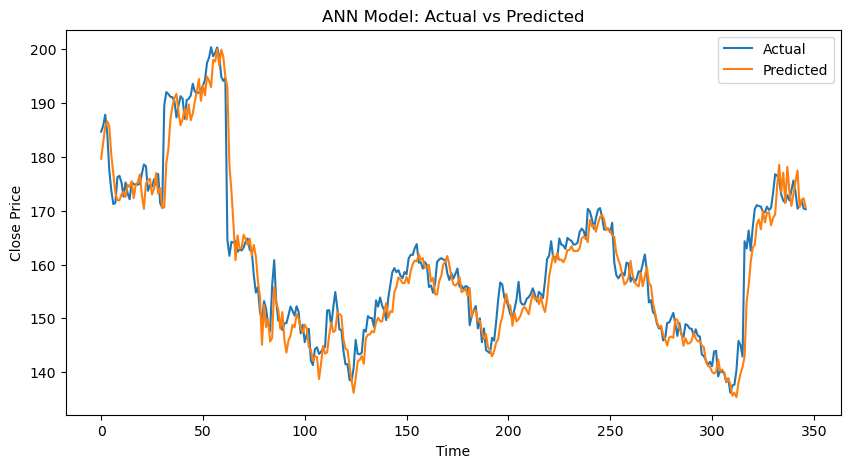

In [37]:
# Plotting actual vs predicted values for ANN Model
plt.figure(figsize=(10, 5))
plt.plot(Y_test_ts_inversed, label='Actual')
plt.plot(Y_pred_ann_ts_inversed, label='Predicted')
plt.title('ANN Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


In [31]:
# Creating and training CNN Model for Time Series
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten

def create_cnn_model(input_shape):
    model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(50, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

cnn_model_ts = create_cnn_model((X_train_ts.shape[1], 1))
cnn_model_ts.fit(X_train_ts, Y_train_ts, epochs=100, batch_size=64, validation_split=0.2)


Epoch 1/100


C:\Users\Poojith\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0370 - val_loss: 0.0013
Epoch 2/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0015 - val_loss: 0.0037
Epoch 3/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.7743e-04 - val_loss: 0.0016
Epoch 4/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.8830e-04 - val_loss: 0.0018
Epoch 5/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.0681e-04 - val_loss: 0.0012
Epoch 6/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.4140e-04 - val_loss: 0.0011
Epoch 7/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 5.5310e-04 - val_loss: 0.0013
Epoch 8/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.2232e-04 - val_loss: 0.0012
Epoch 9/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3626e-04 - val_loss: 9.6062e-04
Epoch 10/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 4.3381e-04 - val_loss: 9.5828e-04
Epoch 11/100
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.9667e-04 - val_loss: 8.9678e-04
Epoch 12/100
18/18 ━━━━━━━

In [32]:
# Predicting with CNN Model
Y_pred_cnn_ts = cnn_model_ts.predict(X_test_ts)
Y_pred_cnn_ts_inversed = scaler_Y.inverse_transform(Y_pred_cnn_ts)  # Inverse scaling

# Evaluating CNN Model for Time Series
print("CNN Time Series R2 score:", r2_score(Y_test_ts_inversed, Y_pred_cnn_ts_inversed))


11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
CNN Time Series R2 score: 0.9133435550008135


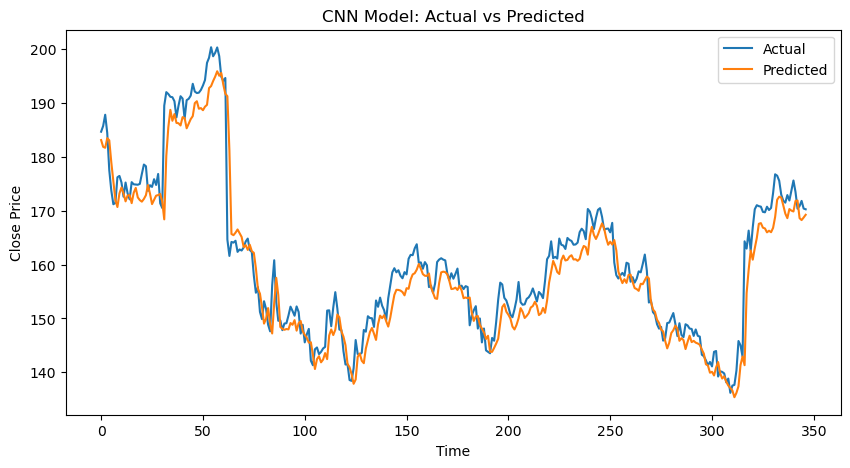

In [38]:
# Plotting actual vs predicted values for CNN Model
plt.figure(figsize=(10, 5))
plt.plot(Y_test_ts_inversed, label='Actual')
plt.plot(Y_pred_cnn_ts_inversed, label='Predicted')
plt.title('CNN Model: Actual vs Predicted')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


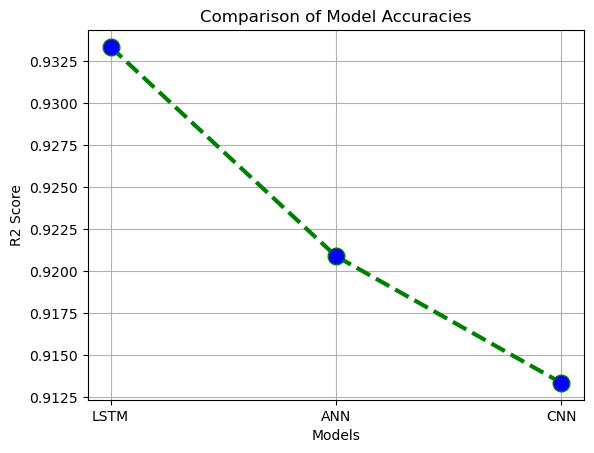

In [41]:
import matplotlib.pyplot as plt

model_scores = [r2_score(Y_test_ts_inversed, Y_pred_lstm_inversed),
                r2_score(Y_test_ts_inversed, Y_pred_ann_ts_inversed),
                r2_score(Y_test_ts_inversed, Y_pred_cnn_ts_inversed)]
model_names = ['LSTM', 'ANN', 'CNN']

plt.plot(range(3), model_scores, color='green', linestyle='dashed', linewidth=3, marker='o', markerfacecolor='blue', markersize=12)
plt.ylabel('R2 Score')
plt.xlabel('Models')
plt.title("Comparison of Model Accuracies")
plt.xticks(range(3), model_names)
plt.grid(True)
plt.show()
